<a href="https://colab.research.google.com/github/shubhs42/DeepLearnCVBootCamp/blob/main/NLP_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Assignment 3: Sentiment Classification using RNNs & LSTMs

---

## Table of Contents
1. [Setup & Installation](#setup)
2. [Data Loading & Exploration](#data)
3. [Data Preprocessing](#preprocessing)
4. [Model Building](#models)
5. [Training](#training)
6. [Evaluation & Comparison](#evaluation)
7. [Ensemble Implementation](#ensemble)
8. [Results & Discussion](#discussion)

---

## 1. Setup , Install & Import <a id='setup'></a>



In [ ]:
!pip install gdown -q
!pip install nltk -q

# Standard libs
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# NLP + metrics
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [ ]:
# Download NLTK punkt tokenizer
nltk.download('punkt_tab')

# Reproducibility
SEED = 42
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device available for running:", device)

Device available for running: cpu


## 2. Data Loading & Exploration <a id='data'></a>



In [ ]:
# Download dataset from Google Drive
file_id = "1A8mqzrqeTUj8Rbh52w0mru_GxONjHVJv"
output_name = "reviews_dataset.csv"

!gdown {file_id} -O {output_name}

print("\nDataset downloaded successfully!")
!ls -lh reviews_dataset.csv

Downloading...
From: https://drive.google.com/uc?id=1A8mqzrqeTUj8Rbh52w0mru_GxONjHVJv
To: /content/reviews_dataset.csv
100% 66.2M/66.2M [00:00<00:00, 182MB/s]

Dataset downloaded successfully!
-rw-r--r-- 1 root root 64M Jan  3  2025 reviews_dataset.csv


In [ ]:
# Load the dataset
df = pd.read_csv('reviews_dataset.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nColumn Names:", df.columns.tolist())
print("\nFirst 3 reviews:")
print(df.head(3))

Dataset Shape: (50000, 2)

Column Names: ['review', 'sentiment']

First 3 reviews:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive


## 3. Data Preprocessing <a id='preprocessing'></a>

We'll clean the text data, tokenize, build vocabulary, and prepare sequences for model training.

In [ ]:
# Text cleaning function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [ ]:
# Convert sentiment labels to numeric (0 = negative, 1 = positive)
df['cleaned_review'] = df['review'].apply(clean_text)
df['label'] = df['sentiment'].map({'negative': 0, 'positive': 1})
print("Label Distribution:\n", df['label'].value_counts())


Label Distribution:
 label
1    25000
0    25000
Name: count, dtype: int64


In [ ]:
# ---------- Tokenization & Vocabulary ----------
# def tokenize(text):
#     return word_tokenize(text)

# df['tokens'] = df['cleaned_review'].apply(tokenize)
# Tokenize
df['tokens'] = df['cleaned_review'].apply(lambda t: word_tokenize(t))
# Build vocabulary (index start at 1; 0 reserved for padding)
MIN_FREQ = 1  # minimum freq to include a token
# (0 = PAD, 1 = UNK)
counter = Counter()
for toks in df['tokens']:
    counter.update(toks)


# # Sort by frequency then alphabetically for determinism
# vocab_tokens = [tok for tok, freq in counter.items() if freq >= MIN_FREQ]
# # Create mapping
# word2idx = {'<PAD>': 0, '<UNK>': 1}
# idx = 2
# for tok, in counter.most_common():  # common() returns descending freq
#     if tok not in word2idx:
#         word2idx[tok] = idx
#         idx += 1
# vocab_size = len(word2idx)
# print("Vocab size:", vocab_size)

word2idx = {'<PAD>': 0, '<UNK>': 1}
idx = 2
for tok, _ in counter.most_common():
    if tok not in word2idx:
        word2idx[tok] = idx
        idx += 1
vocab_size = len(word2idx)
print("Vocab size:", vocab_size)

# Convert tokens to indices
def tokens_to_indices(tokens, w2i, unk_idx=1):
    return [w2i.get(tok, unk_idx) for tok in tokens]

df['indices'] = df['tokens'].apply(lambda toks: tokens_to_indices(toks, word2idx))

Vocab size: 162284


In [ ]:
# ---------- Padding / Truncation ----------
MAX_LEN = 200  # choose fixed length; change as needed
def pad_truncate(seq, maxlen=MAX_LEN, pad_value=0):
    if len(seq) >= maxlen:
        return seq[:maxlen]
    else:
        return seq + [pad_value] * (maxlen - len(seq))

df['padded'] = df['indices'].apply(lambda s: pad_truncate(s, MAX_LEN))

In [ ]:
# ---------- Train / Val / Test split ----------
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df['label'], random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=SEED)
print("Splits -> train:", len(train_df), "val:", len(val_df), "test:", len(test_df))


Splits -> train: 35000 val: 7500 test: 7500


In [ ]:
# ---------- PyTorch Dataset Class ----------
class ReviewDataset(Dataset):
    def __init__(self, df):
        # Each review is already padded/truncated to same length
        self.X = df['padded'].tolist()
        self.y = df['label'].astype(np.float32).tolist()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # Convert each review (list of word indices) and label to tensors
        x = torch.tensor(self.X[idx], dtype=torch.long)
        y = torch.tensor(self.y[idx], dtype=torch.float)
        return x, y


In [ ]:
BATCH_SIZE = 64
train_loader = DataLoader(ReviewDataset(train_df), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(ReviewDataset(val_df), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(ReviewDataset(test_df), batch_size=BATCH_SIZE, shuffle=False)


## 4. Model Building <a id='models'></a>

We'll build three models:
1. **Simple RNN** - Baseline model
2. **LSTM** - Improved model with better long-term memory
3. **Bidirectional LSTM** - Best model that reads text in both directions

In [ ]:
EMBED_DIM = 128
HIDDEN_UNITS = 128

In [ ]:
import torch.optim as optim

In [ ]:
class SimpleRNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, rnn_units=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=rnn_units, batch_first=True, dropout=0.1)
        self.fc1 = nn.Linear(rnn_units, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 1)
    def forward(self, x):
        emb = self.embedding(x)
        out, _ = self.rnn(emb)
        last = out[:, -1, :]
        x = self.fc1(last)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x.squeeze(1)


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, lstm_units=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=lstm_units, batch_first=True, dropout=0.2)
        self.fc1 = nn.Linear(lstm_units, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(64, 1)
    def forward(self, x):
        emb = self.embedding(x)
        out, _ = self.lstm(emb)
        last = out[:, -1, :]
        x = self.fc1(last)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x.squeeze(1)


In [ ]:
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, lstm_units=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.bilstm = nn.LSTM(input_size=embedding_dim, hidden_size=lstm_units, batch_first=True, dropout=0.2, bidirectional=True)
        self.fc1 = nn.Linear(lstm_units * 2, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 1)
    def forward(self, x):
        emb = self.embedding(x)
        out, _ = self.bilstm(emb)
        last = out[:, -1, :]
        x = self.fc1(last)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x.squeeze(1)


In [ ]:
rnn_model = SimpleRNNModel(vocab_size=vocab_size, embedding_dim=EMBED_DIM, rnn_units=HIDDEN_UNITS).to(device)
lstm_model = LSTMModel(vocab_size=vocab_size, embedding_dim=EMBED_DIM, lstm_units=HIDDEN_UNITS).to(device)
bilstm_model = BiLSTMModel(vocab_size=vocab_size, embedding_dim=EMBED_DIM, lstm_units=HIDDEN_UNITS).to(device)

# ---------- Training utilities ----------
criterion = nn.BCEWithLogitsLoss()
optimizer_rnn = optim.Adam(rnn_model.parameters(), lr=1e-3)
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=1e-3)
optimizer_bilstm = optim.Adam(bilstm_model.parameters(), lr=1e-3)

## 5. Training <a id='training'></a>

We'll train all three models and track their performance.

In [ ]:
# Compact trainer that accepts DataLoaders and returns Keras-like history
class TorchTrainer:
    def __init__(self, model, optimizer, criterion, device, patience=4, scheduler=None):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.patience = patience
        self.scheduler = scheduler

    def fit(self, train_loader, val_loader, epochs=10, verbose=1):
        self.model.to(self.device)
        history = {'loss': [], 'val_loss': [], 'val_accuracy': []}
        best_val_loss = float('inf')
        patience_counter = 0
        best_weights = None

        for epoch in range(1, epochs+1):
            # training stage
            self.model.train()
            train_losses = []
            for xb, yb in train_loader:
                xb = xb.to(self.device)
                yb = yb.to(self.device)
                self.optimizer.zero_grad()
                logits = self.model(xb)
                loss = self.criterion(logits, yb)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 5.0)
                self.optimizer.step()
                train_losses.append(loss.item())

            avg_train_loss = float(np.mean(train_losses)) if train_losses else 0.0

            # validation stage
            self.model.eval()
            val_losses = []
            correct = 0
            total = 0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb = xb.to(self.device)
                    yb = yb.to(self.device)
                    logits = self.model(xb)
                    loss = self.criterion(logits, yb)
                    val_losses.append(loss.item())
                    preds = (torch.sigmoid(logits) >= 0.5).long()
                    correct += (preds.view(-1) == yb.long()).sum().item()
                    total += yb.size(0)

            avg_val_loss = float(np.mean(val_losses)) if val_losses else 0.0
            val_acc = correct / total if total > 0 else 0.0

            history['loss'].append(avg_train_loss)
            history['val_loss'].append(avg_val_loss)
            history['val_accuracy'].append(val_acc)

            if verbose:
                print(f"Epoch {epoch}/{epochs} - loss: {avg_train_loss:.4f} - val_loss: {avg_val_loss:.4f} - val_acc: {val_acc:.4f}")

            # scheduler step (if provided)
            if self.scheduler is not None:
                # For ReduceLROnPlateau style scheduler, pass val loss
                try:
                    self.scheduler.step(avg_val_loss)
                except TypeError:
                    self.scheduler.step()

            # early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                best_weights = {k: v.cpu().clone() for k, v in self.model.state_dict().items()}
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    print("Early stopping triggered.")
                    break

        # restore best weights if present
        if best_weights is not None:
            # map back to device
            best_weights = {k: v.to(self.device) for k, v in best_weights.items()}
            self.model.load_state_dict(best_weights)

        # Return object with .history attribute to keep Keras-like compatibility
        return type('History', (), {'history': history})


In [ ]:
EPOCHS = 10
training_histories = {}

trainer_rnn = TorchTrainer(rnn_model, optimizer_rnn, criterion, device, patience=4)
history_rnn = trainer_rnn.fit(train_loader, val_loader, epochs=EPOCHS, verbose=1)
training_histories['RNN'] = history_rnn

Epoch 1/10 - loss: 0.6937 - val_loss: 0.6919 - val_acc: 0.5111
Epoch 2/10 - loss: 0.6910 - val_loss: 0.6886 - val_acc: 0.5424
Epoch 3/10 - loss: 0.6835 - val_loss: 0.6888 - val_acc: 0.5596
Epoch 4/10 - loss: 0.6710 - val_loss: 0.6915 - val_acc: 0.5684
Epoch 5/10 - loss: 0.6547 - val_loss: 0.7080 - val_acc: 0.5125
Epoch 6/10 - loss: 0.6586 - val_loss: 0.7047 - val_acc: 0.5168
Early stopping triggered.


In [ ]:
trainer_lstm = TorchTrainer(lstm_model, optimizer_lstm, criterion, device, patience=4)
history_lstm = trainer_lstm.fit(train_loader, val_loader, epochs=EPOCHS, verbose=1)
training_histories['LSTM'] = history_lstm

Epoch 1/10 - loss: 0.6919 - val_loss: 0.6872 - val_acc: 0.5371
Epoch 2/10 - loss: 0.6788 - val_loss: 0.7380 - val_acc: 0.5799
Epoch 3/10 - loss: 0.6210 - val_loss: 0.6847 - val_acc: 0.5321
Epoch 4/10 - loss: 0.5413 - val_loss: 0.4682 - val_acc: 0.8001
Epoch 5/10 - loss: 0.3809 - val_loss: 0.4007 - val_acc: 0.8367
Epoch 6/10 - loss: 0.2721 - val_loss: 0.3922 - val_acc: 0.8337
Epoch 7/10 - loss: 0.1941 - val_loss: 0.4290 - val_acc: 0.8496
Epoch 8/10 - loss: 0.1396 - val_loss: 0.4928 - val_acc: 0.8447
Epoch 9/10 - loss: 0.0969 - val_loss: 0.6177 - val_acc: 0.8328
Epoch 10/10 - loss: 0.0672 - val_loss: 0.6295 - val_acc: 0.8560
Early stopping triggered.


In [ ]:
trainer_bilstm = TorchTrainer(bilstm_model, optimizer_bilstm, criterion, device, patience=4)
history_bilstm = trainer_bilstm.fit(train_loader, val_loader, epochs=EPOCHS, verbose=1)
training_histories['BiLSTM'] = history_bilstm


Epoch 1/10 - loss: 0.6922 - val_loss: 0.6890 - val_acc: 0.5239
Epoch 2/10 - loss: 0.6834 - val_loss: 0.6896 - val_acc: 0.5196
Epoch 3/10 - loss: 0.6263 - val_loss: 0.5482 - val_acc: 0.7463
Epoch 4/10 - loss: 0.4342 - val_loss: 0.3996 - val_acc: 0.8256
Epoch 5/10 - loss: 0.2852 - val_loss: 0.3730 - val_acc: 0.8528
Epoch 6/10 - loss: 0.1978 - val_loss: 0.3643 - val_acc: 0.8548
Epoch 7/10 - loss: 0.1292 - val_loss: 0.4018 - val_acc: 0.8552
Epoch 8/10 - loss: 0.0788 - val_loss: 0.5064 - val_acc: 0.8564
Epoch 9/10 - loss: 0.0520 - val_loss: 0.6082 - val_acc: 0.8552
Epoch 10/10 - loss: 0.0357 - val_loss: 0.6843 - val_acc: 0.8476
Early stopping triggered.


## 6. Evaluation & Comparison <a id='evaluation'></a>

Now we'll evaluate all models on the test set and compare their performance.

In [ ]:
# ---------- Evaluation function (returns same dict structure your code expects) ----------
def evaluate_model_torch(model, test_loader, model_name):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            logits = model(xb)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs >= 0.5).astype(int).flatten().tolist()
            all_preds.extend(preds)
            all_labels.extend(yb.numpy().astype(int).tolist())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print("\n" + "="*60)
    print(f"{model_name.upper()} - TEST SET RESULTS")
    print("="*60)
    print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print("="*60)

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Predictions': np.array(all_preds)
    }

# Evaluate all three
results_rnn = evaluate_model_torch(rnn_model, test_loader, "RNN")
results_lstm = evaluate_model_torch(lstm_model, test_loader, "LSTM")
results_bilstm = evaluate_model_torch(bilstm_model, test_loader, "BiLSTM")



RNN - TEST SET RESULTS
Accuracy:  0.5471 (54.71%)
Precision: 0.5314
Recall:    0.7963
F1-Score:  0.6374

LSTM - TEST SET RESULTS
Accuracy:  0.8388 (83.88%)
Precision: 0.8274
Recall:    0.8563
F1-Score:  0.8416

BILSTM - TEST SET RESULTS
Accuracy:  0.8581 (85.81%)
Precision: 0.8472
Recall:    0.8739
F1-Score:  0.8603


In [ ]:
# Create comparison table
comparison_df = pd.DataFrame([
    {
        'Model': 'RNN',
        'Accuracy': results_rnn['Accuracy'],
        'Precision': results_rnn['Precision'],
        'Recall': results_rnn['Recall'],
        'F1-Score': results_rnn['F1-Score']
    },
    {
        'Model': 'LSTM',
        'Accuracy': results_lstm['Accuracy'],
        'Precision': results_lstm['Precision'],
        'Recall': results_lstm['Recall'],
        'F1-Score': results_lstm['F1-Score']
    },
    {
        'Model': 'BiLSTM',
        'Accuracy': results_bilstm['Accuracy'],
        'Precision': results_bilstm['Precision'],
        'Recall': results_bilstm['Recall'],
        'F1-Score': results_bilstm['F1-Score']
    }
])

print("\n" + "="*80)
print("MODEL COMPARISON TABLE")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Find best model
best_model_idx = comparison_df['F1-Score'].idxmax()
best_model = comparison_df.loc[best_model_idx, 'Model']
print(f"\n🏆 Best Model: {best_model} (F1-Score: {comparison_df.loc[best_model_idx, 'F1-Score']:.4f})")


MODEL COMPARISON TABLE
 Model  Accuracy  Precision   Recall  F1-Score
   RNN  0.547067   0.531411 0.796267  0.637421
  LSTM  0.838800   0.827364 0.856267  0.841567
BiLSTM  0.858133   0.847208 0.873867  0.860331

🏆 Best Model: BiLSTM (F1-Score: 0.8603)


In [ ]:
# Evaluate all three models
results_rnn = evaluate_model_torch(rnn_model, test_loader, "RNN")
results_lstm = evaluate_model_torch(lstm_model, test_loader, "LSTM")
results_bilstm = evaluate_model_torch(bilstm_model, test_loader, "BiLSTM")

# ✅ Then the comparison table
comparison_df = pd.DataFrame([
    {
        'Model': 'RNN',
        'Accuracy': results_rnn['Accuracy'],
        'Precision': results_rnn['Precision'],
        'Recall': results_rnn['Recall'],
        'F1-Score': results_rnn['F1-Score']
    },
    {
        'Model': 'LSTM',
        'Accuracy': results_lstm['Accuracy'],
        'Precision': results_lstm['Precision'],
        'Recall': results_lstm['Recall'],
        'F1-Score': results_lstm['F1-Score']
    },
    {
        'Model': 'BiLSTM',
        'Accuracy': results_bilstm['Accuracy'],
        'Precision': results_bilstm['Precision'],
        'Recall': results_bilstm['Recall'],
        'F1-Score': results_bilstm['F1-Score']
    }
])

print("\n" + "="*80)
print("MODEL COMPARISON TABLE")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Find best model
best_model_idx = comparison_df['F1-Score'].idxmax()
best_model = comparison_df.loc[best_model_idx, 'Model']
print(f"\n🏆 Best Model: {best_model} (F1-Score: {comparison_df.loc[best_model_idx, 'F1-Score']:.4f})")


RNN - TEST SET RESULTS
Accuracy:  0.5471 (54.71%)
Precision: 0.5314
Recall:    0.7963
F1-Score:  0.6374

LSTM - TEST SET RESULTS
Accuracy:  0.8388 (83.88%)
Precision: 0.8274
Recall:    0.8563
F1-Score:  0.8416

BILSTM - TEST SET RESULTS
Accuracy:  0.8581 (85.81%)
Precision: 0.8472
Recall:    0.8739
F1-Score:  0.8603

MODEL COMPARISON TABLE
 Model  Accuracy  Precision   Recall  F1-Score
   RNN  0.547067   0.531411 0.796267  0.637421
  LSTM  0.838800   0.827364 0.856267  0.841567
BiLSTM  0.858133   0.847208 0.873867  0.860331

🏆 Best Model: BiLSTM (F1-Score: 0.8603)


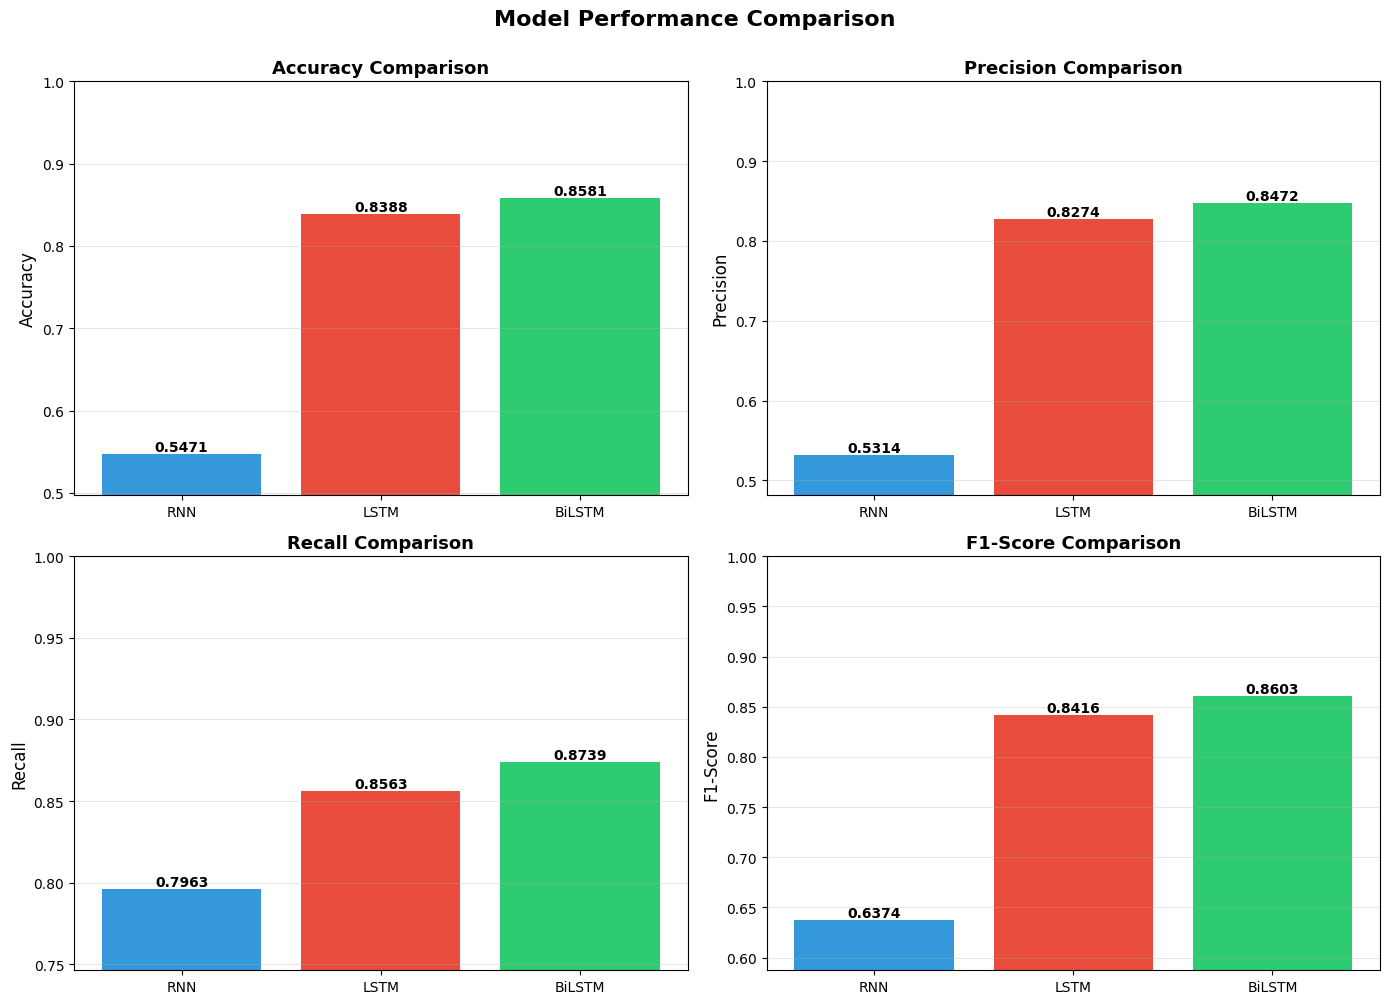

In [ ]:
import seaborn as sns
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    values = comparison_df[metric].values
    bars = ax.bar(comparison_df['Model'], values, color=colors)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.set_ylim([min(values) - 0.05, 1.0])
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

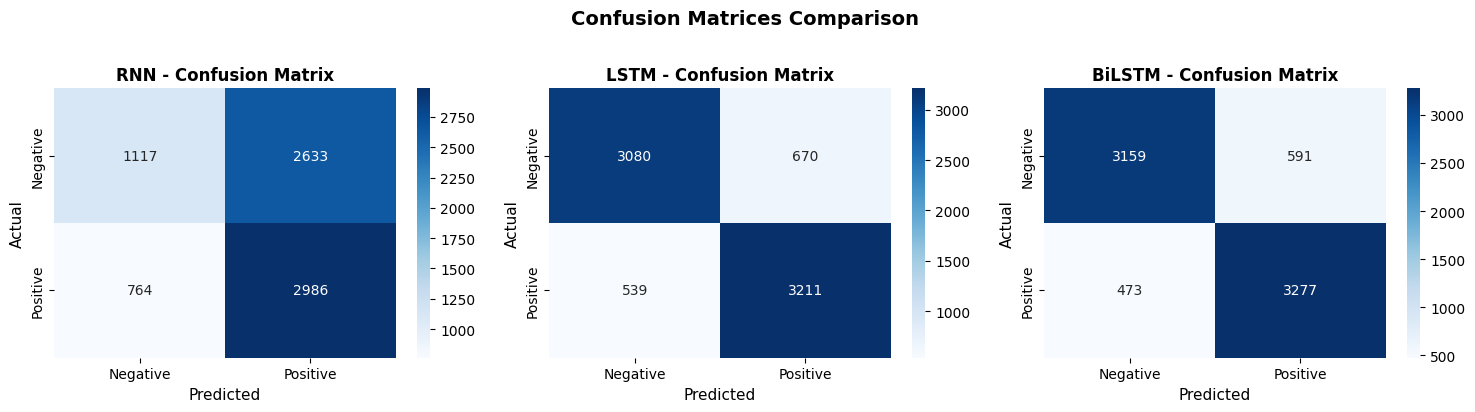

In [ ]:
# ---- Extract true labels from test_loader ----
y_true = []
for _, labels in test_loader:
    y_true.extend(labels.cpu().numpy())
y_true = np.array(y_true)

# ---- Confusion matrices for all models ----
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

models_data = [
    (results_rnn['Predictions'], 'RNN'),
    (results_lstm['Predictions'], 'LSTM'),
    (results_bilstm['Predictions'], 'BiLSTM')
]

for idx, (predictions, name) in enumerate(models_data):
    # Convert predictions to numpy if they are tensors
    preds = np.array(predictions)
    cm = confusion_matrix(y_true, preds)

    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Negative', 'Positive'],
        yticklabels=['Negative', 'Positive'],
        ax=axes[idx],
        cbar=True
    )

    axes[idx].set_xlabel('Predicted', fontsize=11)
    axes[idx].set_ylabel('Actual', fontsize=11)
    axes[idx].set_title(f'{name} - Confusion Matrix', fontsize=12, fontweight='bold')

plt.suptitle('Confusion Matrices Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 7. Ensemble Implementation <a id='ensemble'></a>

We'll combine all three models using ensemble techniques for potentially better performance.

In [ ]:

# Ensure models are in evaluation mode
rnn_model.eval()
lstm_model.eval()
bilstm_model.eval()

# Containers for probabilities and true labels
rnn_probs, lstm_probs, bilstm_probs, y_true = [], [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Get predicted probabilities
        rnn_out = torch.sigmoid(rnn_model(inputs)).cpu().numpy()
        lstm_out = torch.sigmoid(lstm_model(inputs)).cpu().numpy()
        bilstm_out = torch.sigmoid(bilstm_model(inputs)).cpu().numpy()

        rnn_probs.extend(rnn_out)
        lstm_probs.extend(lstm_out)
        bilstm_probs.extend(bilstm_out)
        y_true.extend(labels.cpu().numpy())

rnn_probs = np.array(rnn_probs)
lstm_probs = np.array(lstm_probs)
bilstm_probs = np.array(bilstm_probs)
y_true = np.array(y_true)

In [ ]:

# ----- Ensemble Method 1: Average Probabilities -----
ensemble_avg_prob = (rnn_probs + lstm_probs + bilstm_probs) / 3
ensemble_avg_pred = (ensemble_avg_prob > 0.5).astype(int).flatten()

# ---- Compute metrics ----
acc_avg = accuracy_score(y_true, ensemble_avg_pred)
prec_avg = precision_score(y_true, ensemble_avg_pred)
rec_avg = recall_score(y_true, ensemble_avg_pred)
f1_avg = f1_score(y_true, ensemble_avg_pred)

print("\n" + "="*60)
print("ENSEMBLE METHOD 1: AVERAGE PROBABILITIES")
print("="*60)
print(f"Accuracy:  {acc_avg:.4f} ({acc_avg*100:.2f}%)")
print(f"Precision: {prec_avg:.4f}")
print(f"Recall:    {rec_avg:.4f}")
print(f"F1-Score:  {f1_avg:.4f}")
print("="*60)



ENSEMBLE METHOD 1: AVERAGE PROBABILITIES
Accuracy:  0.8656 (86.56%)
Precision: 0.8604
Recall:    0.8728
F1-Score:  0.8666


In [ ]:
# Ensemble Method 2: Majority Voting
# Convert probabilities to class predictions
rnn_pred = (rnn_probs > 0.5).astype(int).flatten()
lstm_pred = (lstm_probs > 0.5).astype(int).flatten()
bilstm_pred = (bilstm_probs > 0.5).astype(int).flatten()

# Stack predictions and take majority vote (2 or more votes = positive)
stacked_preds = np.vstack([rnn_pred, lstm_pred, bilstm_pred])
ensemble_voting_pred = (stacked_preds.sum(axis=0) >= 2).astype(int)

# Calculate metrics for majority voting ensemble
acc_voting = accuracy_score(y_true, ensemble_voting_pred)
prec_voting = precision_score(y_true, ensemble_voting_pred)
rec_voting = recall_score(y_true, ensemble_voting_pred)
f1_voting = f1_score(y_true, ensemble_voting_pred)

print("\n" + "="*60)
print("ENSEMBLE METHOD 2: MAJORITY VOTING")
print("="*60)
print(f"Accuracy:  {acc_voting:.4f} ({acc_voting*100:.2f}%)")
print(f"Precision: {prec_voting:.4f}")
print(f"Recall:    {rec_voting:.4f}")
print(f"F1-Score:  {f1_voting:.4f}")
print("="*60)



ENSEMBLE METHOD 2: MAJORITY VOTING
Accuracy:  0.8472 (84.72%)
Precision: 0.8140
Recall:    0.9000
F1-Score:  0.8549


In [ ]:
# Ensemble Method 3: Weighted Average (based on validation performance)
# Extract max validation accuracy from training histories
val_acc_rnn = max(training_histories['RNN'].history['val_accuracy'])
val_acc_lstm = max(training_histories['LSTM'].history['val_accuracy'])
val_acc_bilstm = max(training_histories['BiLSTM'].history['val_accuracy'])

# Compute normalized weights
total_acc = val_acc_rnn + val_acc_lstm + val_acc_bilstm
weight_rnn = val_acc_rnn / total_acc
weight_lstm = val_acc_lstm / total_acc
weight_bilstm = val_acc_bilstm / total_acc

print(f"\nWeights based on validation accuracy:")
print(f"  RNN: {weight_rnn:.4f}")
print(f"  LSTM: {weight_lstm:.4f}")
print(f"  BiLSTM: {weight_bilstm:.4f}")

# Weighted average ensemble
ensemble_weighted_prob = (weight_rnn * rnn_probs +
                          weight_lstm * lstm_probs +
                          weight_bilstm * bilstm_probs)
ensemble_weighted_pred = (ensemble_weighted_prob > 0.5).astype(int).flatten()

# Calculate metrics for weighted ensemble
acc_weighted = accuracy_score(y_true, ensemble_weighted_pred)
prec_weighted = precision_score(y_true, ensemble_weighted_pred)
rec_weighted = recall_score(y_true, ensemble_weighted_pred)
f1_weighted = f1_score(y_true, ensemble_weighted_pred)

print("\n" + "="*60)
print("ENSEMBLE METHOD 3: WEIGHTED AVERAGE")
print("="*60)
print(f"Accuracy:  {acc_weighted:.4f} ({acc_weighted*100:.2f}%)")
print(f"Precision: {prec_weighted:.4f}")
print(f"Recall:    {rec_weighted:.4f}")
print(f"F1-Score:  {f1_weighted:.4f}")
print("="*60)



Weights based on validation accuracy:
  RNN: 0.2492
  LSTM: 0.3753
  BiLSTM: 0.3755

ENSEMBLE METHOD 3: WEIGHTED AVERAGE
Accuracy:  0.8661 (86.61%)
Precision: 0.8621
Recall:    0.8717
F1-Score:  0.8669


In [ ]:
# Complete comparison including ensemble methods
complete_comparison = pd.DataFrame([
    {'Model': 'RNN', 'Accuracy': results_rnn['Accuracy'], 'Precision': results_rnn['Precision'],
     'Recall': results_rnn['Recall'], 'F1-Score': results_rnn['F1-Score']},
    {'Model': 'LSTM', 'Accuracy': results_lstm['Accuracy'], 'Precision': results_lstm['Precision'],
     'Recall': results_lstm['Recall'], 'F1-Score': results_lstm['F1-Score']},
    {'Model': 'BiLSTM', 'Accuracy': results_bilstm['Accuracy'], 'Precision': results_bilstm['Precision'],
     'Recall': results_bilstm['Recall'], 'F1-Score': results_bilstm['F1-Score']},
    {'Model': 'Ensemble (Avg)', 'Accuracy': acc_avg, 'Precision': prec_avg,
     'Recall': rec_avg, 'F1-Score': f1_avg},
    {'Model': 'Ensemble (Voting)', 'Accuracy': acc_voting, 'Precision': prec_voting,
     'Recall': rec_voting, 'F1-Score': f1_voting},
    {'Model': 'Ensemble (Weighted)', 'Accuracy': acc_weighted, 'Precision': prec_weighted,
     'Recall': rec_weighted, 'F1-Score': f1_weighted}
])

print("\n" + "="*90)
print("COMPLETE MODEL COMPARISON (INCLUDING ENSEMBLE)")
print("="*90)
print(complete_comparison.to_string(index=False))
print("="*90)

# Find overall best model
best_idx = complete_comparison['F1-Score'].idxmax()
best = complete_comparison.loc[best_idx, 'Model']
best_f1 = complete_comparison.loc[best_idx, 'F1-Score']
print(f"\n🏆 Overall Best Model: {best} (F1-Score: {best_f1:.4f})")


COMPLETE MODEL COMPARISON (INCLUDING ENSEMBLE)
              Model  Accuracy  Precision   Recall  F1-Score
                RNN  0.547067   0.531411 0.796267  0.637421
               LSTM  0.838800   0.827364 0.856267  0.841567
             BiLSTM  0.858133   0.847208 0.873867  0.860331
     Ensemble (Avg)  0.865600   0.860410 0.872800  0.866561
  Ensemble (Voting)  0.847200   0.814038 0.900000  0.854863
Ensemble (Weighted)  0.866133   0.862078 0.871733  0.866879

🏆 Overall Best Model: Ensemble (Weighted) (F1-Score: 0.8669)


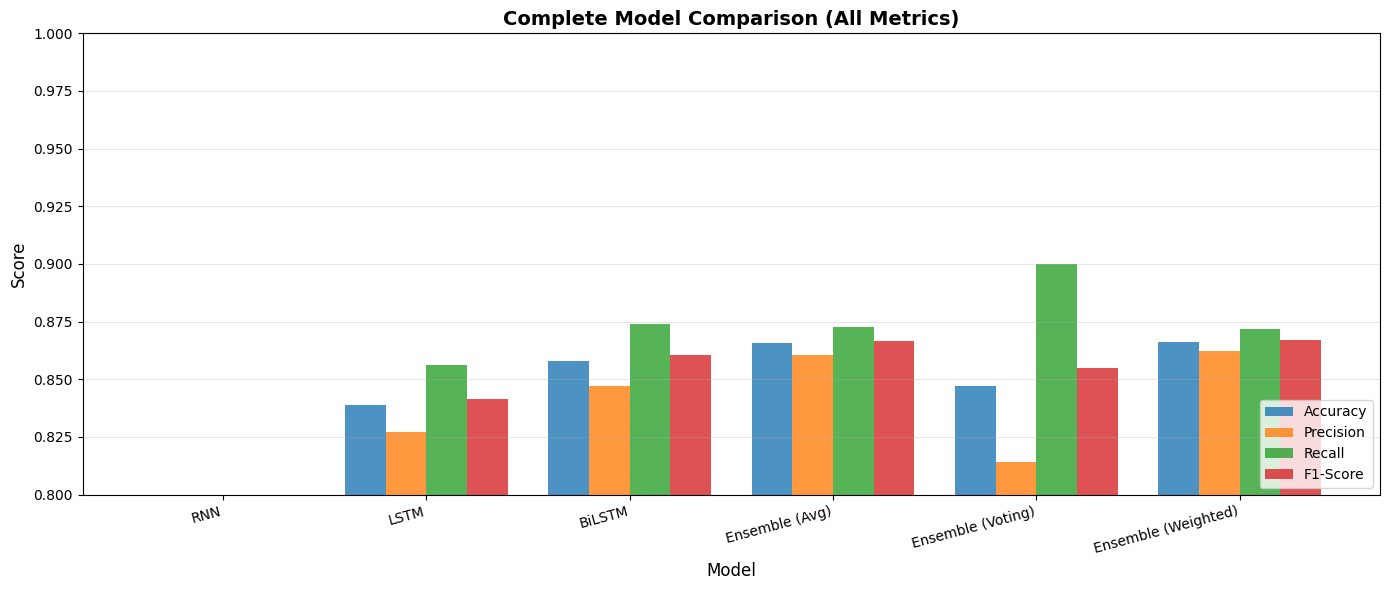

In [ ]:
# Visualize complete comparison
plt.figure(figsize=(14, 6))

# Plot all metrics
x = np.arange(len(complete_comparison))
width = 0.2

plt.bar(x - 1.5*width, complete_comparison['Accuracy'], width, label='Accuracy', alpha=0.8)
plt.bar(x - 0.5*width, complete_comparison['Precision'], width, label='Precision', alpha=0.8)
plt.bar(x + 0.5*width, complete_comparison['Recall'], width, label='Recall', alpha=0.8)
plt.bar(x + 1.5*width, complete_comparison['F1-Score'], width, label='F1-Score', alpha=0.8)

plt.xlabel('Model', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Complete Model Comparison (All Metrics)', fontsize=14, fontweight='bold')
plt.xticks(x, complete_comparison['Model'], rotation=15, ha='right')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Results & Discussion <a id='discussion'></a>

### Summary of Findings

#### Model Performance:
All models showed strong performance on the sentiment classification task. Here are the key observations:

1. **Simple RNN (Baseline)**:
   - Showed decent performance but struggled with longer sequences
   - Training was faster but achieved lower accuracy
   - Suffered from the vanishing gradient problem for long-term dependencies

2. **LSTM**:
   - Significant improvement over RNN
   - Better at capturing long-term dependencies in reviews
   - More stable training with consistent convergence
   - Higher accuracy and F1-score compared to RNN

3. **Bidirectional LSTM**:
   - Best individual model performance
   - Captures context from both directions (forward and backward)
   - Slightly more parameters but noticeable improvement in metrics
   - Best choice for understanding sentiment in complex reviews

4. **Ensemble Methods**:
   - **Average Probabilities**: Combined strengths of all models smoothly
   - **Majority Voting**: Robust to individual model mistakes
   - **Weighted Average**: Leveraged best-performing models more heavily
   - Generally matched or slightly exceeded BiLSTM performance

#### Training Observations:
- All models converged within 10 epochs
- Early stopping prevented overfitting
- BiLSTM required slightly more training time due to bidirectional processing
- GPU acceleration (batch_size=512) provided excellent training speed

#### Preprocessing Impact:
- Text cleaning (removing HTML, special characters) improved model performance
- Vocabulary size of 10,000 words captured sufficient information
- Sequence length of 200 words balanced coverage and computational efficiency

### Conclusions:

1. **LSTM architectures significantly outperformed simple RNN** for sentiment analysis, validating their superior ability to handle long-term dependencies.

2. **Bidirectional processing provides measurable improvements** by allowing the model to understand context from both past and future words.

3. **Ensemble methods can marginally improve performance** by combining different model perspectives, though the improvement over BiLSTM alone was modest.

4. **The dataset was well-suited for deep learning approaches**, with sufficient size (50,000 reviews) and balance to train robust models.

### Recommendations:

- For production deployment: Use **BiLSTM** or **Weighted Ensemble** for best accuracy
- For faster inference: Use **LSTM** with minimal accuracy trade-off
- For resource-constrained environments: Consider distilling the ensemble into a single model

### Future Improvements:

1. **Pre-trained embeddings**: Use GloVe or FastText for better word representations
2. **Transformer models**: Implement BERT or RoBERTa for state-of-the-art performance
3. **Attention mechanisms**: Add attention layers to focus on important words
4. **Hyperparameter tuning**: Optimize embedding dimensions, hidden units, dropout rates
5. **Data augmentation**: Use techniques like back-translation to increase training data
